## Introduction to Random Forests 

In [1]:
# to my understanding, this is used for auto-reloading of modules. For instance, change in the imported module will be automatically reflected in the notebook without restarting the kernel
%load_ext autoreload
%autoreload 2

# instruct python to look for modules in additional places
import sys
sys.path.append('..')

In [2]:
# import of modules needed for the notebook
import matplotlib.pyplot as plt

from ai import *
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# sets the theme for plots to dark
plt.style.use('dark_background')
# sets the size of plots in inches (1 inch = 2.54cm)
plt.rcParams["figure.figsize"] = (20, 7)

# path to the dataset
PATH = "../resources"

In [3]:
# shows from which module function comes from 
display_all

# shows documentation of the function
?display_all

# shows source code of the function
??display_all

# executes shell commands
!pwd

# mixes shell commands and python variables
!ls {PATH}

/home/georggie/DataAnalysis/the-mechanics-of-machine-learning/lessons
bulldozers.csv	rent-ideal.csv


Signature: display_all(dataframe)
Source:   
def display_all(dataframe):
    """
    Displays maximum of 1000 rows and columns for a given data frame.

    Example:
    --------
    >>> df = pd.DataFrame({'col1': ['A', 'B', 'C'], 'col2': [1, 2, 3]})
    >>> display_all(df)
        col1 col2
    0   A        1
    1   B        2
    2   C        3
    """
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(dataframe)
File:      ~/DataAnalysis/the-mechanics-of-machine-learning/ai.py
Type:      function


In [4]:
# load data from CSV to the pandas' data frame
# load_memory = False loads all data in memory, but infers the correct data types for columns
# parse_dates will treat specified columns as dates
data_raw = pd.read_csv(f'{PATH}/bulldozers.csv', low_memory=False, parse_dates=['saledate'])

# display as much as it can be displayed and transpose rows and columns.
display_all(data_raw.head().transpose())

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


Project is evaluated on `RMSLE (Root Mean Square Log Error)`. In other words, we are going to look at the difference between the log of our prediction of price and the log of the actual price and we will square them (differences) and add them up.

In [5]:
# take log of prices since we are working with RMSLE
# now we can optimize of RMSE instead for RMSLE
data_raw.SalePrice = np.log(data_raw.SalePrice)

### 1. Preprocessing

* We should always try to extract new features from a complete `datetime` field. Without expanding datetime into these additional features, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

* Some features in our data set contain string variables which most of the ML algorithms will not accept (do not understand them). We need to convert them to categorical variables.

In [6]:
# extract additional features from date - see ?extract_date_features
extract_date_features(data_raw, 'saledate')

# changes strings data to categorical data type - see ?convert_to_categorical
convert_to_categorical(data_raw)

In [7]:
# when converting `UsageBand` feature to categorical variable we received an order of High < Low < Medium which is not natural (may also cause some inefficiencies).So we decided to put them in natural order. 
data_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

# normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical (but column of ints).
data_raw.UsageBand = data_raw.UsageBand.cat.codes

In [8]:
# we also need to be careful about missing values because they can cause problems in the model training process. Command shows the percentage of missing values in our data set (per feature).
display_all(data_raw.isnull().sum().sort_index()/len(data_raw) * 100)

# save raw data in csv file
data_raw.to_csv('../resources/bulldozers_temp.csv', index=False)

Backhoe_Mounting            80.387161
Blade_Extension             93.712932
Blade_Type                  80.097725
Blade_Width                 93.712932
Coupler                     46.662013
Coupler_System              89.165971
Differential_Type           82.695918
Drive_System                73.982923
Enclosure                    0.081022
Enclosure_Type              93.712932
Engine_Horsepower           93.712932
Forks                       52.115425
Grouser_Tracks              89.189903
Grouser_Type                75.281271
Hydraulics                  20.082269
Hydraulics_Flow             89.189903
MachineHoursCurrentMeter    64.408850
MachineID                    0.000000
ModelID                      0.000000
Pad_Type                    80.271985
Pattern_Changer             75.265067
ProductGroup                 0.000000
ProductGroupDesc             0.000000
ProductSize                 52.545964
Pushblock                   93.712932
Ride_Control                62.952696
Ripper      

We'll replace categories (categorical variables) with their numeric codes, handle missing continuous values (replacing them with median), and split the dependent variable into a separate variable. At this point we have something we can pass to the RandomForest(RF). Let's see what we got.

In [9]:
data, target, changes = preprocess_dataframe(data_raw, 'SalePrice')

model = RandomForestRegressor(n_jobs=-1)
model.fit(data, target)
model.score(data, target)

0.9879576975199497

We got a coefficient of determination R<sup>2</sup> of 0.9879. This coefficient is saying that our model is fitting the data quite well. The more we are closer to 1 the model better fits the data (details in statistics repository).

However, we need a validation set in order to see are we maybe overfitting the data. It may be the case that our model learnt training data quite well but it will generalize quite badly for the future data.



In [10]:
# split data set into training and validation sets
def split_to_training_and_validation(dataframe,sample_size): 
    return dataframe[:sample_size].copy(), dataframe[sample_size:].copy()

# calculate the sizes of the training and validation set
validation_set_size = 12000  # same as Kaggle's test set size
training_set_size = len(data) - validation_set_size

# raw trining and validation set
raw_training_set, raw_validation_set = split_to_training_and_validation(data_raw, training_set_size)

# data ~ data set without traget variable
# target ~ traget variable column
# create separate pairs (features_training_set, target_training_set), (features_validation_set, target_validation_set)
features_training_set, features_validation_set = split_to_training_and_validation(data, training_set_size)
target_training_set, target_validation_set = split_to_training_and_validation(target, training_set_size)

# print the shapes of newly created data sets 
features_training_set.shape, target_training_set.shape, features_validation_set.shape, target_validation_set.shape

((389125, 65), (389125,), (12000, 65), (12000,))

### 2. Random Forests

#### 2.1 Base Model

In [11]:
# calculates RMSE
def RMSE(predicted, actual): 
    return np.sqrt(np.square(predicted - actual).mean())

# helps explain how well model generalizes (is model overfitting) 
def print_score(model):
    results = [RMSE(model.predict(features_training_set), target_training_set), RMSE(model.predict(features_validation_set), target_validation_set), model.score(features_training_set, target_training_set), model.score(features_validation_set, target_validation_set)]
    
    if hasattr(model, 'oob_score_'): 
        results.append(model.oob_score_)

    print(results)

In [12]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 18min 57s, sys: 8.06 s, total: 19min 5s
Wall time: 2min 57s
[0.076417009529607, 0.23542511993141393, 0.9877956430169188, 0.9010186040019301]


Hmm ... After splitting the data to training and validation sets we see that we are overfitting badly. In the "first" model our RMSE is only 0.07, but our "second" model says that RMSE error is now 0.23. Additionally, our model fitted training data quite well, but it does not generalize unseen data on the same level.

#### 2.2 Speeding Things Up

If we need some time to train the model then we lose interactivity. Ideally, we want to train the model relatively fast (under 10s) but still have enough data to capture relationships between features and response variable.


In [13]:
data_raw = pd.read_csv(f'{PATH}/bulldozers_temp.csv', low_memory=True)

# in order to speed up things we will downsample original dataset
data_sample, target_sample, changes_sample = preprocess_dataframe(data_raw, 'SalePrice', subset=30000, na_dict=changes)

# down-sampled data set is split into training and validation data sets 
features_training_set, _ = split_to_training_and_validation(data_sample, 20000)
target_training_set, _ = split_to_training_and_validation(target_sample, 20000)

features_training_set.reset_index(drop=True, inplace=True)
target_training_set.reset_index(drop=True, inplace=True)

model = RandomForestRegressor(n_jobs=-1)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 31.3 s, sys: 93.8 ms, total: 31.4 s
Wall time: 5.05 s
[0.09436005618565212, 0.3593393248705105, 0.9807516897645023, 0.7694009737793371]


#### 2.3 Single Tree

[0.5293363327486302, 0.582655582957689, 0.39426922843977374, 0.3937220152570371]


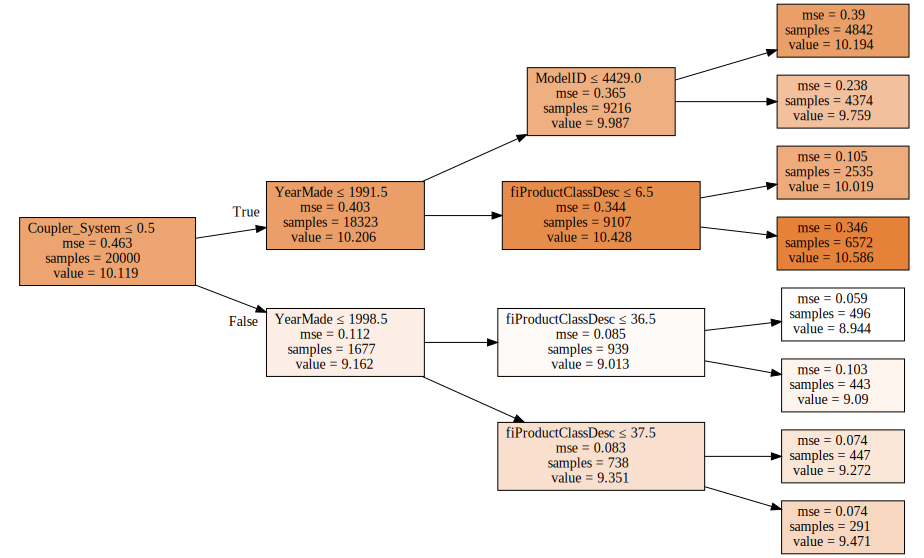

In [14]:
# we are training only one tree with max_depth = 3
# boostrap = False turns of randomizations introduced by Random Forest (we will see later what is randomized)
model = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
model.fit(features_training_set, target_training_set)
print_score(model)

# so, this is not a good model but at least we can draw it and study it from there
draw_tree(model.estimators_[0], features_training_set, precision=3, size=20)

Let's see what is happening when we let the tree grow to the maximum size. Fitting on the training set looks amazing. However, our model generalizes poorly as it overfits pretty badly. That's why we are going to use bunch of these trees to get more generalizable results.   

In [15]:
# model with one tree that will overfit the data
model = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
model.fit(features_training_set, target_training_set)
print_score(model)

[4.864753555590494e-17, 0.5302372469551184, 1.0, 0.4979020621785617]


#### 2.4 Bagging

In bagging, we are taking a sample from our dataset and train one model on that sample. We repeat the procedure with new samples and new models. This way we get a bunch of models whose predictions we are going to average in order to report the final prediction.

In [16]:
# create base model of random forest. By default sklearn creates 10 estimators
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time model.fit(features_training_set, target_training_set)
print_score(model)

features_validation_set.reset_index(drop=True, inplace=True)
target_validation_set.reset_index(drop=True, inplace=True)

predictions = np.stack([tree.predict(features_validation_set) for tree in model.estimators_])

CPU times: user 3.02 s, sys: 62.5 ms, total: 3.08 s
Wall time: 705 ms
[0.11460639671945057, 0.38104729059714226, 0.971605518355692, 0.7406980815540736]


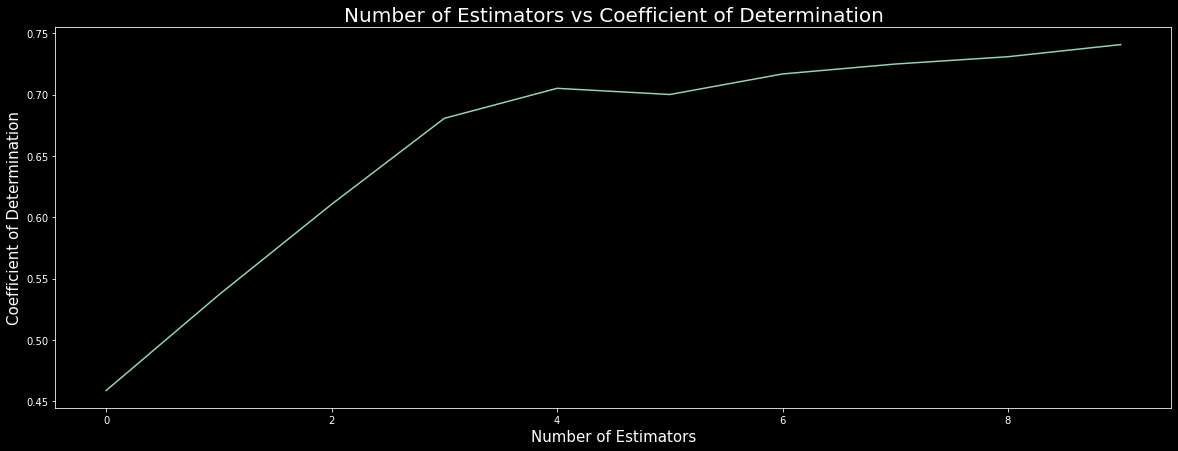

In [17]:
plt.plot([metrics.r2_score(target_validation_set, np.mean(predictions[:i+1], axis=0)) for i in range(10)])

plt.xlabel('Number of Estimators', fontsize=15, fontweight=500)
plt.ylabel('Coefficient of Determination', fontsize=15, fontweight=500)
plt.title('Number of Estimators vs Coefficient of Determination', fontsize=20, fontweight=500)
plt.show()

As we can see, as the number of estimators is raising the coefficient of determination is also going up. However, at some point, the curve flattens which means that adding new estimators will not significantly improve the model.

In [18]:
model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 6.06 s, sys: 31.2 ms, total: 6.09 s
Wall time: 1.21 s
[0.1023930786815893, 0.36573028268345914, 0.9773349108992082, 0.7611254855344649]


In [19]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 12.4 s, sys: 125 ms, total: 12.5 s
Wall time: 2.06 s
[0.0975287423343129, 0.365583284178921, 0.9794372367183156, 0.7613174693067197]


In [20]:
model = RandomForestRegressor(n_estimators=80, n_jobs=-1)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 25.4 s, sys: 125 ms, total: 25.5 s
Wall time: 4.42 s
[0.09522029435287221, 0.3615303723258257, 0.980399133644756, 0.7665802761883542]


#### 2.5 Out-of-bag (OOB) score

In our case, the validation set has a different time period then the training set. The question is: are we less predictive because of the validation set time period or because our model is overfitting?

Additionally, sometimes our data set is small and we don't want to pull out the validation set. In this case, we can use Out-Of-Bag (OOB) score to see how we model generalizes. Rows that are not used in training of the particular tree can serve as a validation set for that tree. Now, total prediction for a row would be average of all predictions for that row in trees where that row was not used for training of that tree. This allows us to see whether the model is overfitting, without needing a separate validation set.

In [21]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 12.3 s, sys: 78.1 ms, total: 12.4 s
Wall time: 2.25 s
[0.09772350212343267, 0.3668744651572181, 0.9793550291960641, 0.7596285158894411, 0.8526974983356336]


#### 2.6 Tree building parameters

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf` (usually: 5, 10, 25)) that we require some minimum number of rows in every leaf node.


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree but also using a sample of columns for each split. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

* None
* 0.5
* 'sqrt'


In [22]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 10.3 s, sys: 78.1 ms, total: 10.4 s
Wall time: 2.05 s
[0.14020226403865543, 0.348653945471473, 0.957506130300566, 0.7829113377963757, 0.8522858990343658]


In [23]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 6.67 s, sys: 93.8 ms, total: 6.77 s
Wall time: 1.71 s
[0.14781249130755547, 0.3463769575973799, 0.9521025721321912, 0.7857376023180118, 0.8499815697549359]
